# Setup

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import random

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

print("CUDA dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA dostępna: True
Nazwa GPU: NVIDIA GeForce RTX 4080 SUPER


# Load and Preprocess Data

In [10]:
import os
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torch
from tqdm import tqdm

SAMPLE_RATE = 16000
NUM_SAMPLES = 16000
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512

class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, classes, split='train', transform=None, use_silence_background=False):
        self.classes = classes.copy()
        self.transform = transform
        self.resampler = T.Resample(orig_freq=16000, new_freq=SAMPLE_RATE)
        self.use_silence_background = use_silence_background

        val_list = self._load_list(os.path.join(root_dir, '..', 'validation_list.txt'))
        test_list = self._load_list(os.path.join(root_dir, '..', 'testing_list.txt'))

        include = set()
        exclude = set()

        if split == 'train':
            exclude = set(val_list + test_list)
        elif split == 'val':
            include = set(val_list)
        elif split == 'test':
            include = set(test_list)
        else:
            raise ValueError("split must be one of: 'train', 'val', 'test'")

        self.filepaths = []
        self.labels = []

        original_classes = classes.copy()

        # Process original classes
        for label, cls in enumerate(original_classes):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for file in os.listdir(cls_dir):
                if not file.endswith('.wav'):
                    continue
                rel_path = os.path.join(cls, file).replace('\\', '/')
                if (split == 'train' and rel_path in exclude) or (split in ['val', 'test'] and rel_path not in include):
                    continue
                self.filepaths.append(os.path.join(cls_dir, file))
                self.labels.append(label)

        if self.use_silence_background:
            # Add 'unknown' and 'silence' to classes
            self.classes = original_classes + ['unknown', 'silence']
            unknown_label = len(original_classes)
            silence_label = len(original_classes) + 1

            # Process unknown class
            for dir_name in os.listdir(root_dir):
                dir_path = os.path.join(root_dir, dir_name)
                if os.path.isdir(dir_path) and dir_name not in original_classes and dir_name != '_background_noise_':
                    for file in os.listdir(dir_path):
                        if not file.endswith('.wav'):
                            continue
                        rel_path = os.path.join(dir_name, file).replace('\\', '/')
                        if (split == 'train' and rel_path in exclude) or (split in ['val', 'test'] and rel_path not in include):
                            continue
                        self.filepaths.append(os.path.join(dir_path, file))
                        self.labels.append(unknown_label)

            # Process silence class
            self.background_waveforms = {}  # Stores resampled waveforms for background noise files
            background_noise_dir = os.path.join(root_dir, '_background_noise_')
            if os.path.isdir(background_noise_dir):
                # Load and resample all background noise files
                for file in os.listdir(background_noise_dir):
                    if not file.endswith('.wav'):
                        continue
                    file_path = os.path.join(background_noise_dir, file)
                    waveform, sample_rate = torchaudio.load(file_path)
                    waveform = self.resampler(waveform)
                    self.background_waveforms[file] = waveform

                # Split each into segments and add to dataset
                for file, waveform in self.background_waveforms.items():
                    num_samples = waveform.size(1)
                    num_segments = num_samples // SAMPLE_RATE
                    # Determine split ranges
                    if split == 'train':
                        start = 0
                        end = int(0.8 * num_segments)
                    elif split == 'val':
                        start = int(0.8 * num_segments)
                        end = int(0.9 * num_segments)
                    elif split == 'test':
                        start = int(0.9 * num_segments)
                        end = num_segments
                    # Add each segment in the range
                    for i in range(start, end):
                        self.filepaths.append((file, i))
                        self.labels.append(silence_label)

    def _load_list(self, file_path):
        if not os.path.exists(file_path):
            return []
        with open(file_path, 'r') as f:
            return [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        if isinstance(filepath, tuple):
            # Handle silence sample
            file_name, segment_idx = filepath
            waveform = self.background_waveforms[file_name]
            start_sample = segment_idx * SAMPLE_RATE
            end_sample = start_sample + SAMPLE_RATE
            segment = waveform[:, start_sample:end_sample]
        else:
            # Handle other samples
            waveform, sample_rate = torchaudio.load(filepath)
            waveform = self.resampler(waveform)

        # Ensure correct length
        if waveform.shape[1] < NUM_SAMPLES:
            padding = (0, NUM_SAMPLES - waveform.shape[1])
            waveform = torch.nn.functional.pad(waveform, padding)
        else:
            waveform = waveform[:, :NUM_SAMPLES]

        # Apply transform
        if self.transform:
            spec = self.transform(waveform)
            spec = spec.squeeze(0)
        else:
            spec = waveform.squeeze(0)

        return spec, self.labels[idx]

mel_spectrogram = torch.nn.Sequential(
    T.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    ),
    T.AmplitudeToDB()
)

classes = ['yes', 'no', 'up', 'down']

root_audio = "./data/train/audio/"
use_silence_background = False
train_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='train', transform=mel_spectrogram, use_silence_background=use_silence_background)
val_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='val', transform=mel_spectrogram, use_silence_background=use_silence_background)
test_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='test', transform=mel_spectrogram, use_silence_background=use_silence_background)
if use_silence_background:
    classes.append("unknown")
    classes.append("silence")
print(f"[LOG]: Liczba próbek treningowych: {len(train_dataset)}")
print(f"[LOG]: Liczba próbek walidacyjnych: {len(val_dataset)}")
print(f"[LOG]: Liczba próbek testowych: {len(test_dataset)}")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

[LOG]: Liczba próbek treningowych: 7398
[LOG]: Liczba próbek walidacyjnych: 1055
[LOG]: Liczba próbek testowych: 1033


### Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# Single Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Multi-head attention with residual and norm
        attn_output, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feedforward network with residual and norm
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src

# Full Transformer Encoder
class AudioTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=3, num_classes=2, dim_feedforward=256, dropout = 0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: [batch, mel, time] -> [batch, time, mel]
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # global average pooling
        return self.classifier(x)


# Train

In [12]:
def train(model, loader, optimizer, criterion, epoch, device):
    model.train()
    total_loss = 0
    correct = 0
    batch_losses = []

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val
        batch_losses.append(loss_val)

        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Train Epoch: {epoch}\tLoss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return avg_loss, acc, batch_losses


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    batch_losses = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            loss_val = loss.item()
            total_loss += loss_val
            batch_losses.append(loss_val)

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Validation: Average loss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return avg_loss, acc, batch_losses


In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns

def score_model(y_true, y_pred, model_name = "Model"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")


def training_details_plot(batch_loses_train, batch_loses_validate, title, smoothness = 0.9):
    def smooth_curve(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    train_loses = smooth_curve(batch_loses_train, smoothness)
    valid_loses = smooth_curve(batch_loses_validate, smoothness)

    plt.figure(figsize=(10, 4))
    plt.plot(train_loses, label="Train Loss")
    plt.plot(valid_loses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [14]:
import os
from collections import defaultdict


results = defaultdict(dict)
model_save_dir = "saved_transformer_models"
os.makedirs(model_save_dir, exist_ok=True)


enc_layers = [1, 3]
heads = [2, 4]
dim_FF = [128, 256]

for el in enc_layers:
    for h in heads:
        for d in dim_FF:

            config_key = f"layers{el}_heads{h}_ff{d}"
            print(f"[LOG] === Start training model: {config_key} ===")

            model = AudioTransformer(
                input_dim = N_MELS,
                d_model = 128,
                nhead = h,
                num_layers = el,
                num_classes = len(classes),
                dim_feedforward = d
            ).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)
            criterion = nn.CrossEntropyLoss()

            best_val_acc = 0
            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            model_path = os.path.join(model_save_dir, f"model_{config_key}.pth")

            for epoch in range(1, 11):
                train_loss, train_acc, batch_train = train(model, train_loader, optimizer, criterion, epoch, device)
                val_loss, val_acc, batch_val = evaluate(model, val_loader, criterion, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_train)
                batch_losses_valid_all.extend(batch_val)
            
            torch.save(model.state_dict(), model_path)
            print(f"[LOG] Best model saved: {model_path} (Val Acc: {val_acc:.2f}%)")
            
            results[config_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
                "best_val_acc": best_val_acc,
                "params": {
                    "layers": el,
                    "heads": h,
                    "ff_dim": d
                }
            }

[LOG] === Start training model: layers1_heads2_ff128 ===
Train Epoch: 1	Loss: 1.1225	Accuracy: 56.22%
Validation: Average loss: 0.8840	Accuracy: 66.64%
Train Epoch: 2	Loss: 0.7697	Accuracy: 71.74%
Validation: Average loss: 0.6506	Accuracy: 75.73%
Train Epoch: 3	Loss: 0.5865	Accuracy: 78.12%
Validation: Average loss: 0.5099	Accuracy: 80.66%
Train Epoch: 4	Loss: 0.4816	Accuracy: 82.25%
Validation: Average loss: 0.4453	Accuracy: 83.60%
Train Epoch: 5	Loss: 0.4218	Accuracy: 84.71%
Validation: Average loss: 0.4358	Accuracy: 84.83%
Train Epoch: 6	Loss: 0.3829	Accuracy: 86.32%
Validation: Average loss: 0.3859	Accuracy: 86.07%
Train Epoch: 7	Loss: 0.3511	Accuracy: 88.02%
Validation: Average loss: 0.3605	Accuracy: 86.26%
Train Epoch: 8	Loss: 0.3322	Accuracy: 88.08%
Validation: Average loss: 0.3357	Accuracy: 88.15%
Train Epoch: 9	Loss: 0.3017	Accuracy: 89.44%
Validation: Average loss: 0.3283	Accuracy: 88.44%
Train Epoch: 10	Loss: 0.2830	Accuracy: 90.08%
Validation: Average loss: 0.3287	Accuracy:


=== Configuration: layers1_heads2_ff128 ===


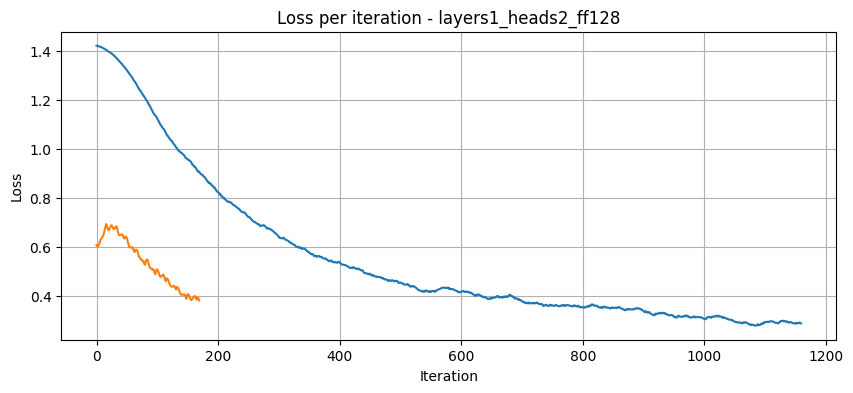

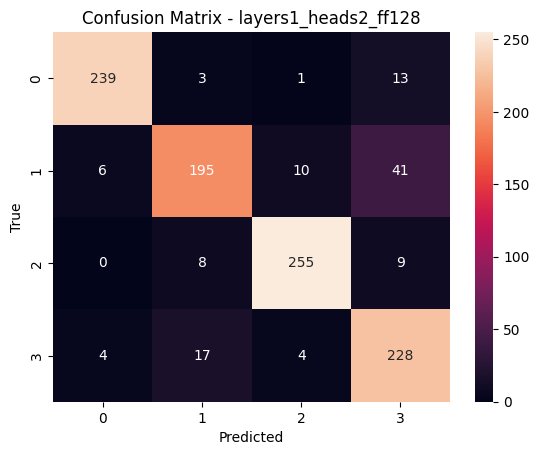

Metrics for layers1_heads2_ff128:
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       256
           1       0.87      0.77      0.82       252
           2       0.94      0.94      0.94       272
           3       0.78      0.90      0.84       253

    accuracy                           0.89      1033
   macro avg       0.89      0.89      0.89      1033
weighted avg       0.89      0.89      0.89      1033


=== Configuration: layers1_heads2_ff256 ===


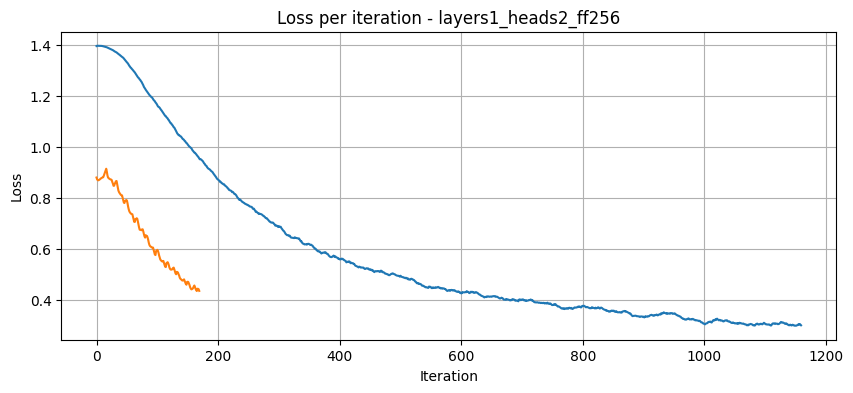

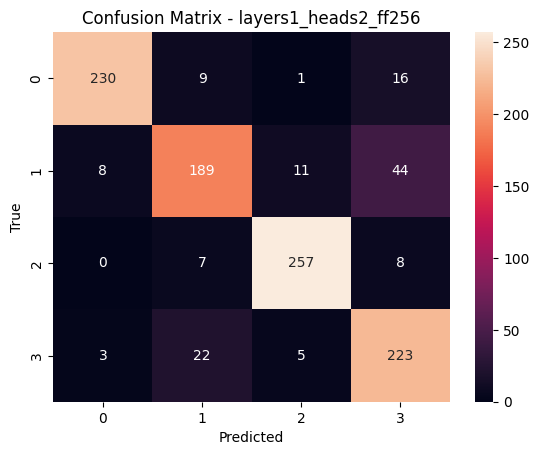

Metrics for layers1_heads2_ff256:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       256
           1       0.83      0.75      0.79       252
           2       0.94      0.94      0.94       272
           3       0.77      0.88      0.82       253

    accuracy                           0.87      1033
   macro avg       0.87      0.87      0.87      1033
weighted avg       0.87      0.87      0.87      1033


=== Configuration: layers1_heads4_ff128 ===


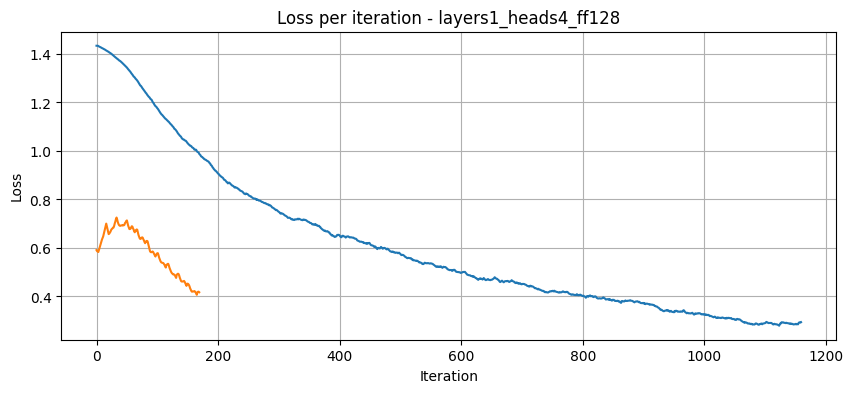

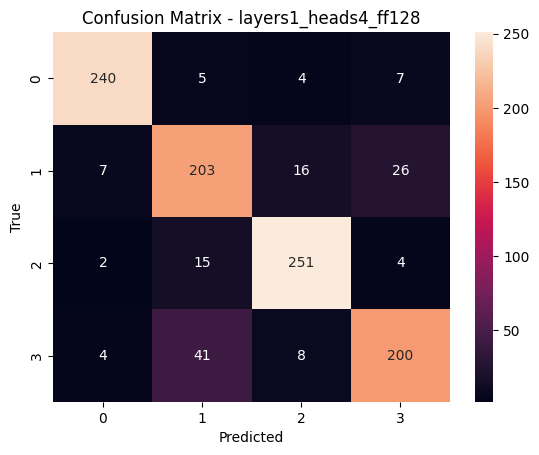

Metrics for layers1_heads4_ff128:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       256
           1       0.77      0.81      0.79       252
           2       0.90      0.92      0.91       272
           3       0.84      0.79      0.82       253

    accuracy                           0.87      1033
   macro avg       0.87      0.86      0.86      1033
weighted avg       0.87      0.87      0.87      1033


=== Configuration: layers1_heads4_ff256 ===


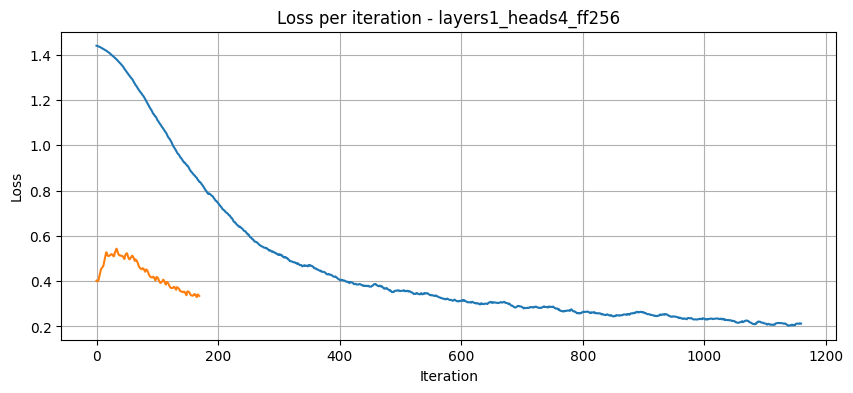

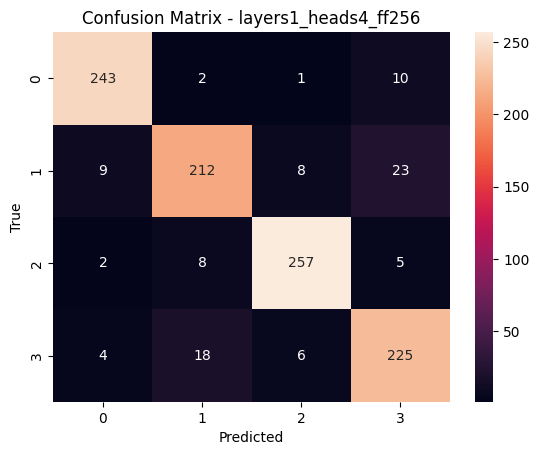

Metrics for layers1_heads4_ff256:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       256
           1       0.88      0.84      0.86       252
           2       0.94      0.94      0.94       272
           3       0.86      0.89      0.87       253

    accuracy                           0.91      1033
   macro avg       0.91      0.91      0.91      1033
weighted avg       0.91      0.91      0.91      1033


=== Configuration: layers3_heads2_ff128 ===


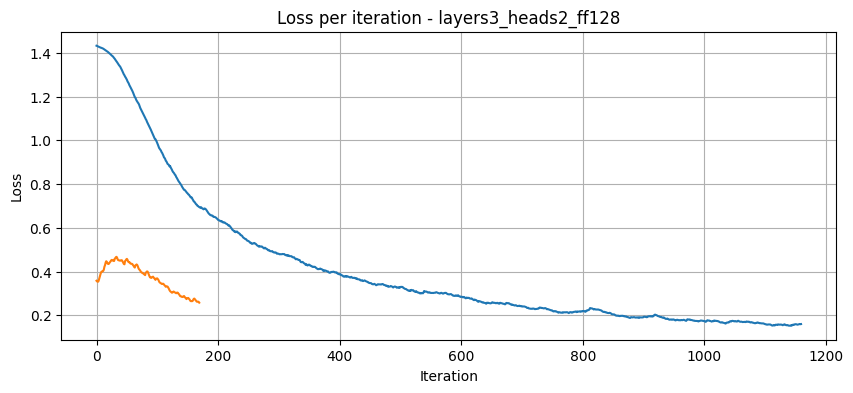

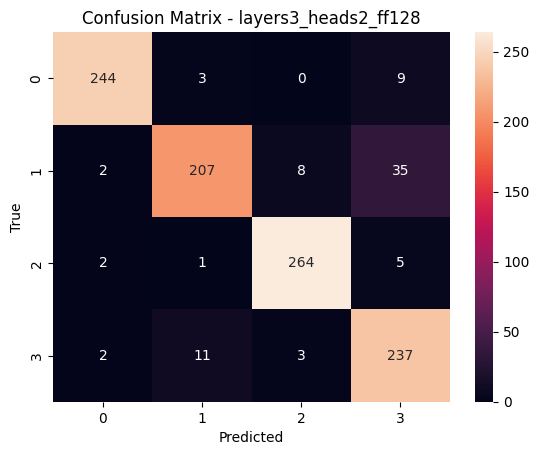

Metrics for layers3_heads2_ff128:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       256
           1       0.93      0.82      0.87       252
           2       0.96      0.97      0.97       272
           3       0.83      0.94      0.88       253

    accuracy                           0.92      1033
   macro avg       0.92      0.92      0.92      1033
weighted avg       0.93      0.92      0.92      1033


=== Configuration: layers3_heads2_ff256 ===


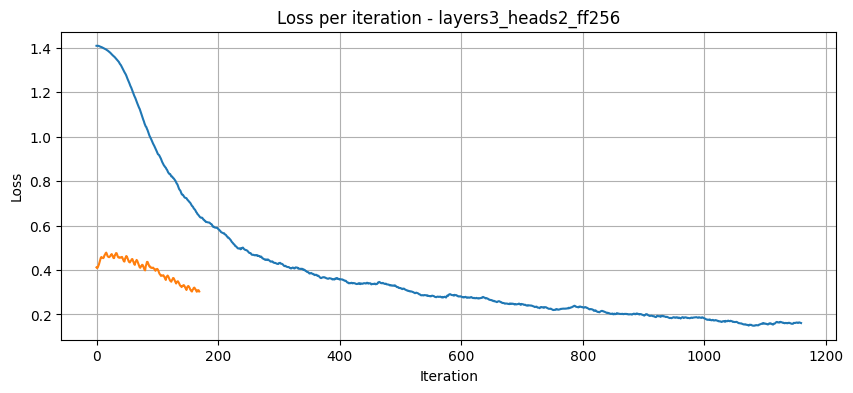

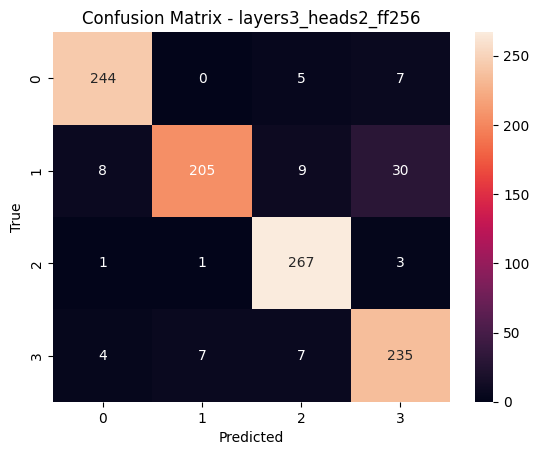

Metrics for layers3_heads2_ff256:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       256
           1       0.96      0.81      0.88       252
           2       0.93      0.98      0.95       272
           3       0.85      0.93      0.89       253

    accuracy                           0.92      1033
   macro avg       0.92      0.92      0.92      1033
weighted avg       0.92      0.92      0.92      1033


=== Configuration: layers3_heads4_ff128 ===


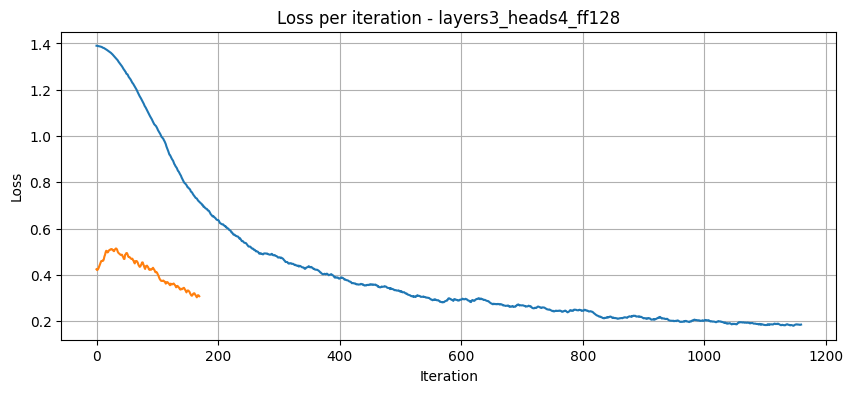

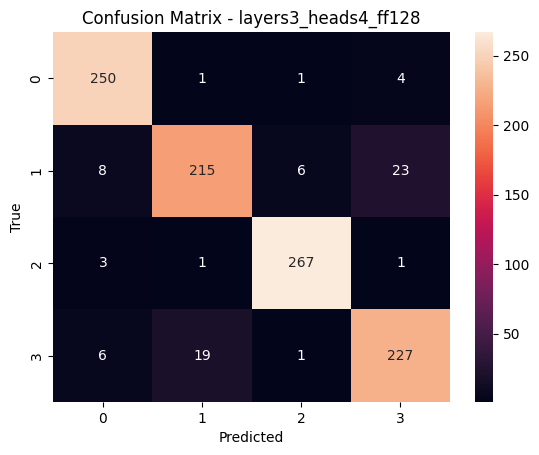

Metrics for layers3_heads4_ff128:
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       256
           1       0.91      0.85      0.88       252
           2       0.97      0.98      0.98       272
           3       0.89      0.90      0.89       253

    accuracy                           0.93      1033
   macro avg       0.93      0.93      0.93      1033
weighted avg       0.93      0.93      0.93      1033


=== Configuration: layers3_heads4_ff256 ===


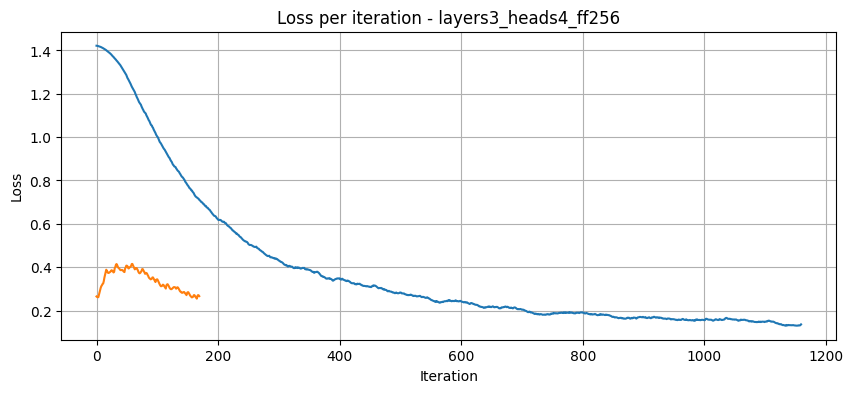

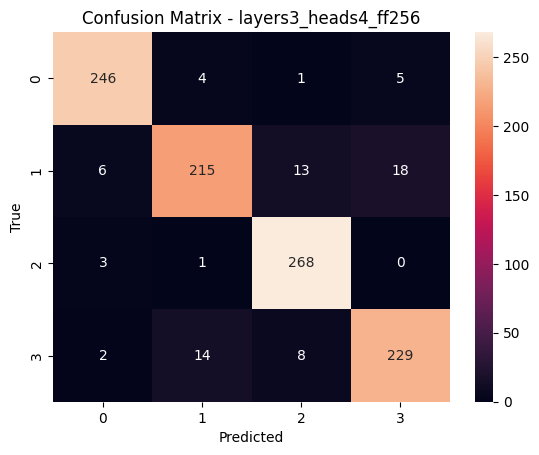

Metrics for layers3_heads4_ff256:
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       256
           1       0.92      0.85      0.88       252
           2       0.92      0.99      0.95       272
           3       0.91      0.91      0.91       253

    accuracy                           0.93      1033
   macro avg       0.93      0.93      0.93      1033
weighted avg       0.93      0.93      0.93      1033



In [15]:
for config_name, data in results.items():
        print(f"\n=== Configuration: {config_name} ===")

        # Odtwórz model
        model = AudioTransformer(
            input_dim=N_MELS,
            d_model=128,
            nhead=data["params"]["heads"],
            num_layers=data["params"]["layers"],
            num_classes=len(classes),
            dim_feedforward=data["params"]["ff_dim"]
        ).to(device)

        model.load_state_dict(torch.load(data["model_path"]))
        model.eval()

        # Rysuj loss plot
        training_details_plot(
            batch_loses_train=data["batch_losses_train"],
            batch_loses_validate=data["batch_losses_valid"],
            title=f"Loss per iteration - {config_name}",
            smoothness=0.98
        )

        # Predykcja na zbiorze testowym
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Wyświetl metryki i confusion matrix
        score_model(all_labels, all_preds, model_name=config_name)

In [16]:
class SpeechCommandRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: [B, N_MELS, TIME] → chcemy [B, TIME, N_MELS]
        x = x.transpose(1, 2)
        output, (hidden, _) = self.lstm(x)  # hidden: [num_layers, B, hidden_size]
        out = hidden[-1]  # bierzemy wyjście z ostatniej warstwy RNN
        return self.classifier(out)


In [17]:
import os
from collections import defaultdict

# Stwórz katalog na modele
model_save_dir_rnn = "saved_rnn_models"
os.makedirs(model_save_dir_rnn, exist_ok=True)

# Wyniki
rnn_results = defaultdict(dict)

# Hiperparametry do testów
hidden_sizes = [64, 128]
num_layers_list = [2, 3]

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:

        config_key = f"hidden{hidden_size}_layers{num_layers}"
        print(f"[LOG] === Start training RNN model: {config_key} ===")

        rnn_model = SpeechCommandRNN(
            input_size=N_MELS,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=len(classes)
        ).to(device)

        optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
        criterion_rnn = nn.CrossEntropyLoss()

        best_val_acc = 0
        train_losses = []
        val_losses = []
        val_accuracies = []
        batch_losses_train_all = []
        batch_losses_valid_all = []

        model_path = os.path.join(model_save_dir_rnn, f"rnn_model_{config_key}.pth")

        for epoch in range(1, 11):  # możesz dać np. 10 epok
            train_loss, train_acc, batch_train = train(rnn_model, train_loader, optimizer_rnn, criterion_rnn, epoch, device)
            val_loss, val_acc, batch_val = evaluate(rnn_model, val_loader, criterion_rnn, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            batch_losses_train_all.extend(batch_train)
            batch_losses_valid_all.extend(batch_val)


        torch.save(rnn_model.state_dict(), model_path)
        print(f"[LOG] New best RNN model saved: {model_path} (Val Acc: {val_acc:.2f}%)")

        rnn_results[config_key] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "batch_losses_train": batch_losses_train_all,
            "batch_losses_valid": batch_losses_valid_all,
            "model_path": model_path,
            "best_val_acc": best_val_acc,
            "params": {
                "hidden_size": hidden_size,
                "num_layers": num_layers
            }
        }


[LOG] === Start training RNN model: hidden64_layers2 ===
Train Epoch: 1	Loss: 1.3628	Accuracy: 35.47%
Validation: Average loss: 1.2886	Accuracy: 45.12%
Train Epoch: 2	Loss: 1.1293	Accuracy: 48.19%
Validation: Average loss: 0.9879	Accuracy: 56.30%
Train Epoch: 3	Loss: 0.9429	Accuracy: 57.39%
Validation: Average loss: 0.7944	Accuracy: 67.01%
Train Epoch: 4	Loss: 0.7630	Accuracy: 65.42%
Validation: Average loss: 0.6937	Accuracy: 68.34%
Train Epoch: 5	Loss: 0.6734	Accuracy: 68.82%
Validation: Average loss: 0.6435	Accuracy: 70.43%
Train Epoch: 6	Loss: 0.6264	Accuracy: 70.68%
Validation: Average loss: 0.6305	Accuracy: 72.61%
Train Epoch: 7	Loss: 0.5915	Accuracy: 72.48%
Validation: Average loss: 0.6154	Accuracy: 73.84%
Train Epoch: 8	Loss: 0.5657	Accuracy: 73.28%
Validation: Average loss: 0.5803	Accuracy: 74.88%
Train Epoch: 9	Loss: 0.5308	Accuracy: 75.74%
Validation: Average loss: 0.5830	Accuracy: 77.25%
Train Epoch: 10	Loss: 0.5183	Accuracy: 77.02%
Validation: Average loss: 0.5289	Accuracy:


=== RNN Configuration: hidden64_layers2 ===


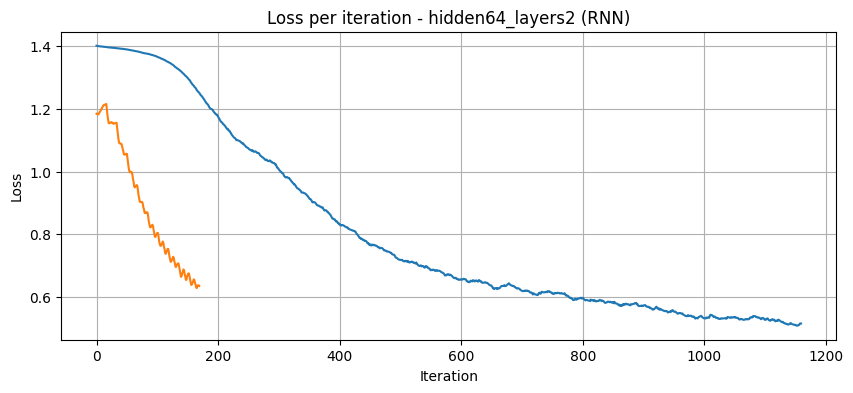

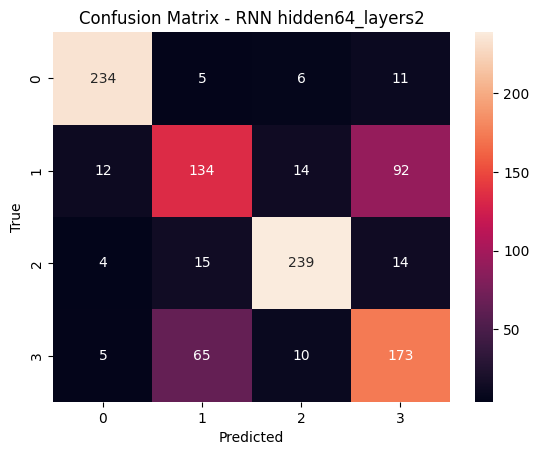

Metrics for RNN hidden64_layers2:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       256
           1       0.61      0.53      0.57       252
           2       0.89      0.88      0.88       272
           3       0.60      0.68      0.64       253

    accuracy                           0.76      1033
   macro avg       0.75      0.75      0.75      1033
weighted avg       0.76      0.76      0.75      1033


=== RNN Configuration: hidden64_layers3 ===


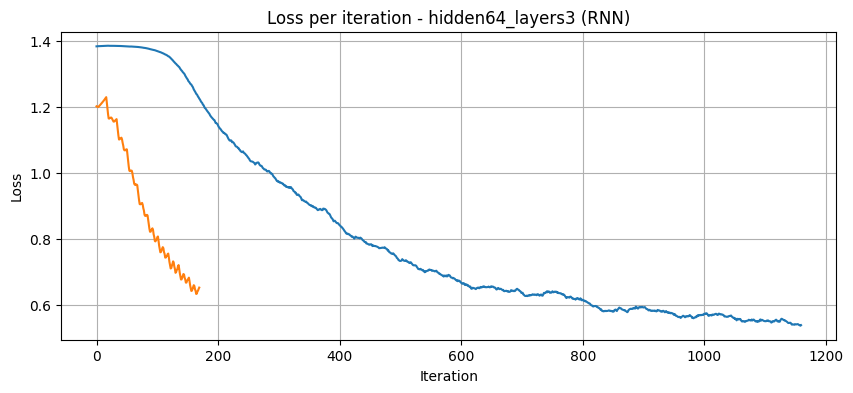

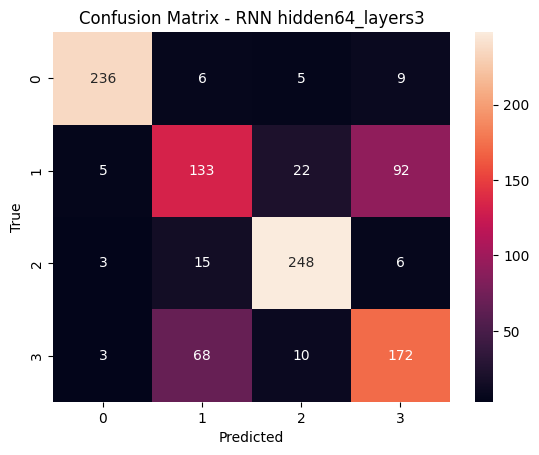

Metrics for RNN hidden64_layers3:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       256
           1       0.60      0.53      0.56       252
           2       0.87      0.91      0.89       272
           3       0.62      0.68      0.65       253

    accuracy                           0.76      1033
   macro avg       0.76      0.76      0.76      1033
weighted avg       0.76      0.76      0.76      1033


=== RNN Configuration: hidden128_layers2 ===


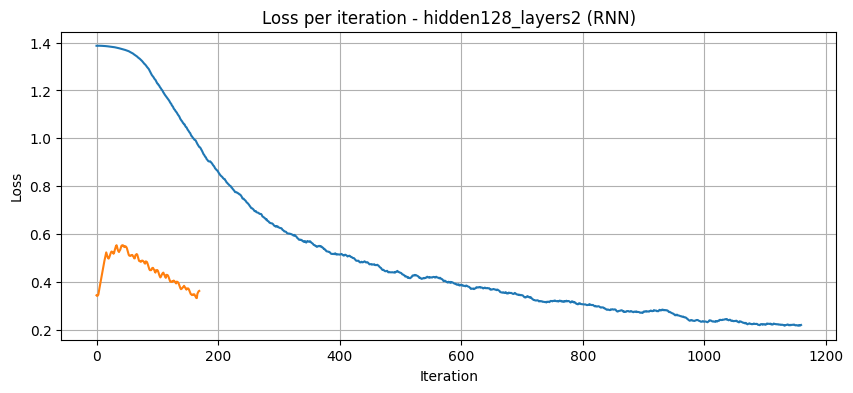

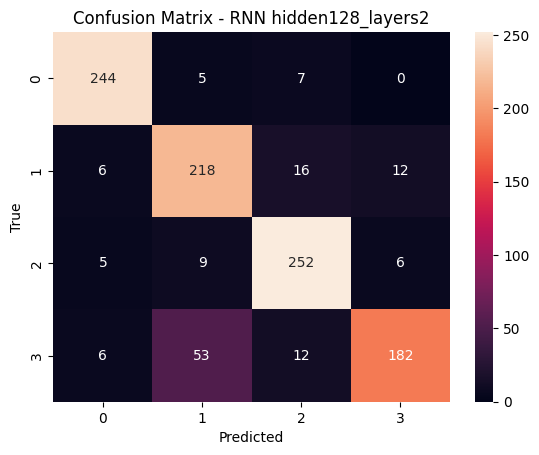

Metrics for RNN hidden128_layers2:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       256
           1       0.76      0.87      0.81       252
           2       0.88      0.93      0.90       272
           3       0.91      0.72      0.80       253

    accuracy                           0.87      1033
   macro avg       0.87      0.87      0.87      1033
weighted avg       0.87      0.87      0.87      1033


=== RNN Configuration: hidden128_layers3 ===


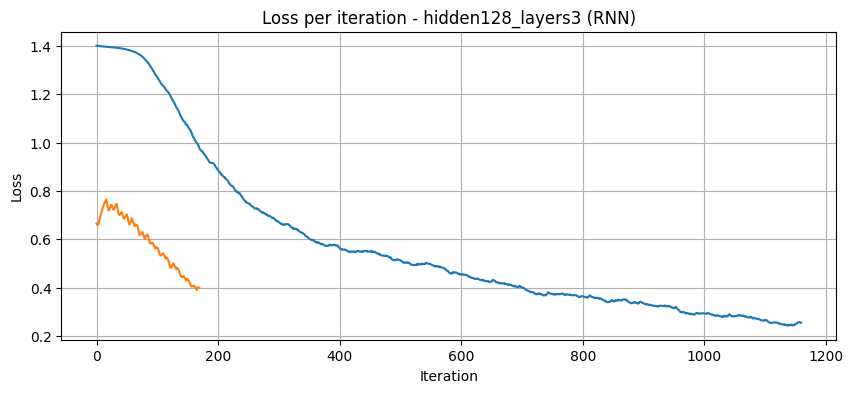

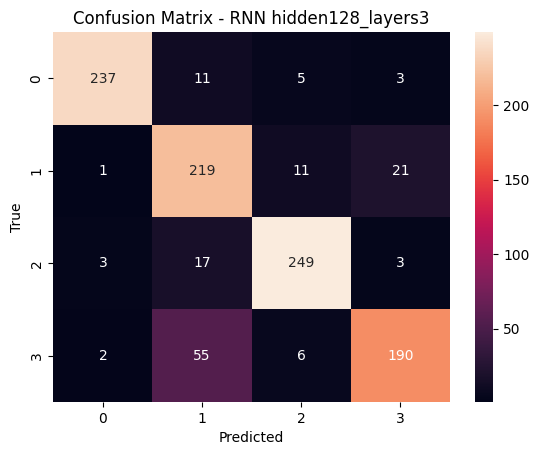

Metrics for RNN hidden128_layers3:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       256
           1       0.73      0.87      0.79       252
           2       0.92      0.92      0.92       272
           3       0.88      0.75      0.81       253

    accuracy                           0.87      1033
   macro avg       0.87      0.87      0.87      1033
weighted avg       0.87      0.87      0.87      1033



In [18]:
for config_name, data in rnn_results.items():
    print(f"\n=== RNN Configuration: {config_name} ===")

    # Odtwórz model RNN
    model = SpeechCommandRNN(
        input_size=N_MELS,
        hidden_size=data["params"]["hidden_size"],
        num_layers=data["params"]["num_layers"],
        num_classes=len(classes)
    ).to(device)

    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()

    # Rysuj wykres lossów
    training_details_plot(
        batch_loses_train=data["batch_losses_train"],
        batch_loses_validate=data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name} (RNN)",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Wyświetl metryki i confusion matrix
    score_model(all_labels, all_preds, model_name=f"RNN {config_name}")


# Best model all classes

In [19]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
    'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
    'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow'] #, '_background_noise_']

root_audio = "./data/train/audio/"

train_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='train', transform=mel_spectrogram)
val_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='val', transform=mel_spectrogram)
test_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='test', transform=mel_spectrogram)

print(f"[LOG]: Liczba próbek treningowych: {len(train_dataset)}")
print(f"[LOG]: Liczba próbek walidacyjnych: {len(val_dataset)}")
print(f"[LOG]: Liczba próbek testowych: {len(test_dataset)}")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


model_save_dir = "saved_transformer_models"
os.makedirs(model_save_dir, exist_ok=True)

# This was the best model
enc_layers = 3
heads = 4
dim_FF = 256

config_key = f"layers{enc_layers}_heads{heads}_ff{dim_FF}_all_classes_silence"
print(f"[LOG] === Start training model: {config_key} ===")

model = AudioTransformer(
    input_dim = N_MELS,
    d_model = 128,
    nhead = heads,
    num_layers = enc_layers,
    num_classes = len(classes),
    dim_feedforward = dim_FF
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []
batch_losses_train_all = []
batch_losses_valid_all = []

model_path = os.path.join(model_save_dir, f"model_{config_key}.pth")

for epoch in range(1, 11):
    train_loss, train_acc, batch_train = train(model, train_loader, optimizer, criterion, epoch, device)
    val_loss, val_acc, batch_val = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    batch_losses_train_all.extend(batch_train)
    batch_losses_valid_all.extend(batch_val)
    
best_val_acc = val_acc
torch.save(model.state_dict(), model_path)
print(f"[LOG] Last model saved: {model_path} (Val Acc: {val_acc:.2f}%)")

results[config_key] = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "batch_losses_train": batch_losses_train_all,
    "batch_losses_valid": batch_losses_valid_all,
    "model_path": model_path,
    "best_val_acc": best_val_acc,
    "params": {
        "layers": enc_layers,
        "heads": heads,
        "ff_dim": dim_FF
    }
}

[LOG]: Liczba próbek treningowych: 51088
[LOG]: Liczba próbek walidacyjnych: 6798
[LOG]: Liczba próbek testowych: 6835
[LOG] === Start training model: layers3_heads4_ff256_all_classes_silence ===
Train Epoch: 1	Loss: 2.2788	Accuracy: 36.73%
Validation: Average loss: 1.3932	Accuracy: 61.99%
Train Epoch: 2	Loss: 1.0852	Accuracy: 70.01%
Validation: Average loss: 0.8883	Accuracy: 74.12%
Train Epoch: 3	Loss: 0.7702	Accuracy: 77.89%
Validation: Average loss: 0.7121	Accuracy: 79.44%
Train Epoch: 4	Loss: 0.6355	Accuracy: 81.74%
Validation: Average loss: 0.6326	Accuracy: 81.35%
Train Epoch: 5	Loss: 0.5507	Accuracy: 83.99%
Validation: Average loss: 0.6028	Accuracy: 83.04%
Train Epoch: 6	Loss: 0.4913	Accuracy: 85.68%
Validation: Average loss: 0.5320	Accuracy: 84.22%
Train Epoch: 7	Loss: 0.4450	Accuracy: 87.01%
Validation: Average loss: 0.5174	Accuracy: 84.95%
Train Epoch: 8	Loss: 0.4074	Accuracy: 88.22%
Validation: Average loss: 0.4756	Accuracy: 85.80%
Train Epoch: 9	Loss: 0.3788	Accuracy: 89.03%


=== Configuration: layers3_heads4_ff256_all_classes_silence ===
layers3_heads4_ff256_all_classes_silence


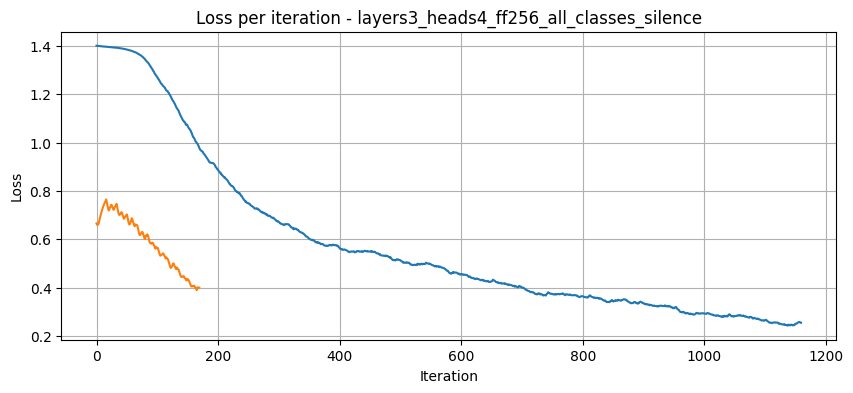

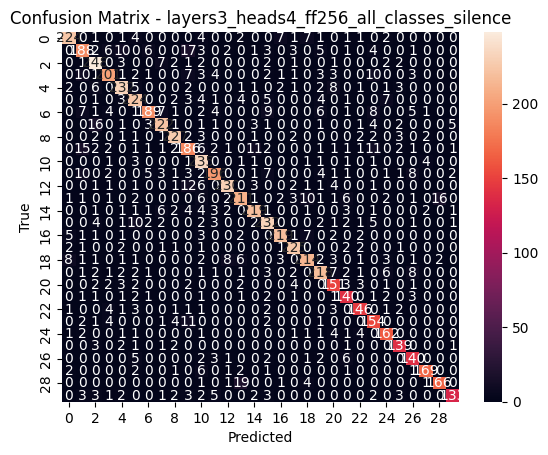

Metrics for layers3_heads4_ff256_all_classes_silence:
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       256
           1       0.77      0.75      0.76       252
           2       0.83      0.91      0.87       272
           3       0.87      0.79      0.83       253
           4       0.86      0.87      0.86       267
           5       0.82      0.86      0.84       259
           6       0.90      0.77      0.83       246
           7       0.88      0.85      0.86       262
           8       0.91      0.91      0.91       249
           9       0.73      0.74      0.74       251
          10       0.77      0.94      0.85       250
          11       0.88      0.79      0.83       248
          12       0.93      0.87      0.90       264
          13       0.84      0.79      0.81       267
          14       0.89      0.87      0.88       253
          15       0.83      0.86      0.84

In [20]:
       
print(f"\n=== Configuration: {config_key} ===")

# Odtwórz model
model = AudioTransformer(
    input_dim=N_MELS,
    d_model=128,
    nhead=heads,
    num_layers=enc_layers,
    num_classes=len(classes),
    dim_feedforward=dim_FF
).to(device)

print(config_key)
model.load_state_dict(torch.load(f'saved_transformer_models/model_{config_key}.pth'))
model.eval()

# Rysuj loss plot
training_details_plot(
    batch_loses_train=data["batch_losses_train"],
    batch_loses_validate=data["batch_losses_valid"],
    title=f"Loss per iteration - {config_key}",
    smoothness=0.98
)

# Predykcja na zbiorze testowym
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Wyświetl metryki i confusion matrix
score_model(all_labels, all_preds, model_name=config_key)

# With silence and unknown

In [22]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] #, '_background_noise_']

root_audio = "./data/train/audio/"

use_silence_background = True
train_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='train', transform=mel_spectrogram, use_silence_background=use_silence_background)
val_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='val', transform=mel_spectrogram, use_silence_background=use_silence_background)
test_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='test', transform=mel_spectrogram, use_silence_background=use_silence_background)
if use_silence_background:
    classes.append("unknown")
    classes.append("silence")
print(f"[LOG]: Liczba próbek treningowych: {len(train_dataset)}")
print(f"[LOG]: Liczba próbek walidacyjnych: {len(val_dataset)}")
print(f"[LOG]: Liczba próbek testowych: {len(test_dataset)}")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


model_save_dir = "saved_transformer_models"
os.makedirs(model_save_dir, exist_ok=True)

# This was the best model
enc_layers = 3
heads = 4
dim_FF = 256

config_key = f"layers{enc_layers}_heads{heads}_ff{dim_FF}_all_classes_silence"
print(f"[LOG] === Start training model: {config_key} ===")

model = AudioTransformer(
    input_dim = N_MELS,
    d_model = 128,
    nhead = heads,
    num_layers = enc_layers,
    num_classes = len(classes),
    dim_feedforward = dim_FF
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []
batch_losses_train_all = []
batch_losses_valid_all = []

model_path = os.path.join(model_save_dir, f"model_{config_key}.pth")

for epoch in range(1, 11):
    train_loss, train_acc, batch_train = train(model, train_loader, optimizer, criterion, epoch, device)
    val_loss, val_acc, batch_val = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    batch_losses_train_all.extend(batch_train)
    batch_losses_valid_all.extend(batch_val)
    
best_val_acc = val_acc
torch.save(model.state_dict(), model_path)
print(f"[LOG] Last model saved: {model_path} (Val Acc: {val_acc:.2f}%)")

results[config_key] = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "batch_losses_train": batch_losses_train_all,
    "batch_losses_valid": batch_losses_valid_all,
    "model_path": model_path,
    "best_val_acc": best_val_acc,
    "params": {
        "layers": enc_layers,
        "heads": heads,
        "ff_dim": dim_FF
    }
}

[LOG]: Liczba próbek treningowych: 51404
[LOG]: Liczba próbek walidacyjnych: 6837
[LOG]: Liczba próbek testowych: 6878
[LOG] === Start training model: layers3_heads4_ff256_all_classes_silence ===
Train Epoch: 1	Loss: 1.2183	Accuracy: 66.10%
Validation: Average loss: 0.8625	Accuracy: 72.03%
Train Epoch: 2	Loss: 0.7123	Accuracy: 77.35%
Validation: Average loss: 0.5866	Accuracy: 80.49%
Train Epoch: 3	Loss: 0.5279	Accuracy: 83.40%
Validation: Average loss: 0.4975	Accuracy: 84.28%
Train Epoch: 4	Loss: 0.4274	Accuracy: 86.44%
Validation: Average loss: 0.4301	Accuracy: 86.18%
Train Epoch: 5	Loss: 0.3779	Accuracy: 88.02%
Validation: Average loss: 0.4041	Accuracy: 87.06%
Train Epoch: 6	Loss: 0.3407	Accuracy: 89.10%
Validation: Average loss: 0.3753	Accuracy: 87.95%
Train Epoch: 7	Loss: 0.3070	Accuracy: 90.20%
Validation: Average loss: 0.3662	Accuracy: 88.53%
Train Epoch: 8	Loss: 0.2787	Accuracy: 91.13%
Validation: Average loss: 0.3566	Accuracy: 88.56%
Train Epoch: 9	Loss: 0.2590	Accuracy: 91.59%


=== Configuration: layers3_heads4_ff256_all_classes_silence ===
layers3_heads4_ff256_all_classes_silence


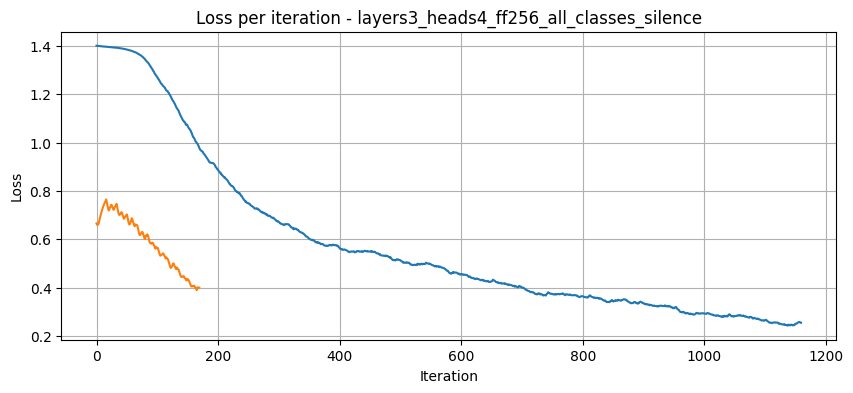

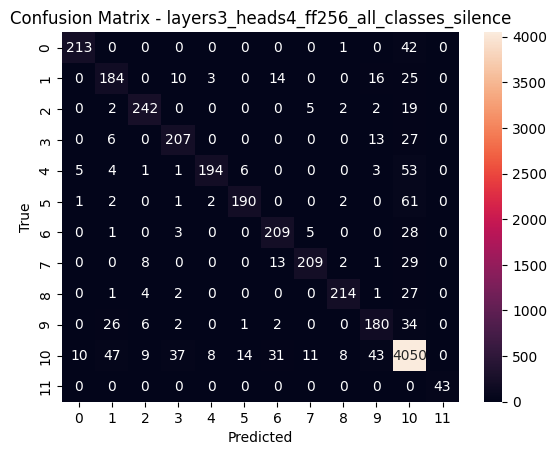

Metrics for layers3_heads4_ff256_all_classes_silence:
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       256
           1       0.67      0.73      0.70       252
           2       0.90      0.89      0.89       272
           3       0.79      0.82      0.80       253
           4       0.94      0.73      0.82       267
           5       0.90      0.73      0.81       259
           6       0.78      0.85      0.81       246
           7       0.91      0.80      0.85       262
           8       0.93      0.86      0.90       249
           9       0.69      0.72      0.71       251
          10       0.92      0.95      0.94      4268
          11       1.00      1.00      1.00        43

    accuracy                           0.89      6878
   macro avg       0.86      0.83      0.84      6878
weighted avg       0.89      0.89      0.89      6878



In [ ]:
print(f"\n=== Configuration: {config_key} ===")

# Odtwórz model
model = AudioTransformer(
    input_dim=N_MELS,
    d_model=128,
    nhead=heads,
    num_layers=enc_layers,
    num_classes=len(classes),
    dim_feedforward=dim_FF
).to(device)

print(config_key)
model.load_state_dict(torch.load(f'saved_transformer_models/model_{config_key}.pth'))
model.eval()

# Rysuj loss plot
training_details_plot(
    batch_loses_train=data["batch_losses_train"],
    batch_loses_validate=data["batch_losses_valid"],
    title=f"Loss per iteration - {config_key}",
    smoothness=0.98
)

# Predykcja na zbiorze testowym
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Wyświetl metryki i confusion matrix
score_model(all_labels, all_preds, model_name=config_key)